# PIA - Reinforcement Learning

1. **RL Intro**
2. Dynamic Programing
3. Tabular Q-Learning
4. Deep Reinforcement Learning (DQN)

## 1. RL Intro (30-45 min)

In this first part you will recap some basics from the Reinforcement Learning literature. Namely, you will examine a simple **Markov Decision Process (MDP)** in the form of a gridworld environment, its observations, actions, rewards etc. and how to use them in order to build an intelligent RL agent.

---
### Course of Action

* Please write all executable python code in ```Code```-Cells (```Cell```->```Cell Type```->```Code```) and all Text as [Markdown](http://commonmark.org/help/) in ```Markdown```-Cells
* Describe your thinking and your decisions (where appropriate) in an extra Markdown Cell or via Python comments
* In general: discuss all your results and comment on them (are they good/bad/unexpected, could they be improved, how?, etc.). Furthermore, visualise your data (input and output).
* Write a short general conclusion at the end of the notebook
* Further experiments are encouraged. However, don't forget to comment on your reasoning.
* Use a scientific approach for all experiments (i.e. develop a hypothesis or concrete question, make observations, evaluate results)

### Submission

E-Mail your complete Notebook to [maucher@hdm-stuttgart.de](mailto:maucher@hdm-stuttgart.de) until the start of the next lecture. One Notebook per Group is enough. Edit the teammember table below.

**Important**: Also attach a HTML version of your notebook (```File```->```Download as```->```HTML```) in addition to the ```.ipynb```-File.

| Teammember |                    |
|------------|--------------------|
| 1.         | Christopher Caldwell |
| 2.         | Fabian Müller      |
| 3.         | An Dang         |

## Prerequisites

- Install the **[pycolab](https://github.com/deepmind/pycolab)** engine and the **[exitgames](https://gitlab.mi.hdm-stuttgart.de/theodoridis/gridworlds)** gridworlds. The `pip -e` option will simply **link** the folders so python can find them. Just place them somewhere convenient in your system, e.g. next to your notebooks.

```
git clone https://github.com/deepmind/pycolab.git
pip install -e pycolab

git clone https://gitlab.mi.hdm-stuttgart.de/theodoridis/gridworlds.git
pip install -e gridworlds
```

- WINDOWS ONLY: `pycolab` requires the `curses` package which is not available by default. To install a compatible binary, [download the corresponding version from here](https://www.lfd.uci.edu/~gohlke/pythonlibs/#curses). For instance, choose **"curses‑2.2+utf8‑cp36‑cp36m‑win_amd64.whl"** for python 3.6 on a 64 bit system. Then install with:

```
pip install curses‑2.2+utf8‑cp36‑cp36m‑win_amd64.whl
```

- For this notebook no further reading is necessary. However, we strongly recommend that you are familiar with the basic concepts of reinforcement learning! Some good resources are:

    1. Johannes Maucher's [lecture on RL](https://maucher.home.hdm-stuttgart.de/MachineLearning/WS1718/V12Reinforcement.pdf) - chapter 1 & 2.
    2. David Silver's course on RL: [Lecture 1](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html), [Youtube](https://www.youtube.com/watch?v=2pWv7GOvuf0).
    3. Sutton & Barto: [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html) chapter 1 & 3 (complete online pdf draft available).

Now, the best way to start is simply to:

### Play the game

> Note: In order to play, you must focus the pygame window! To play again, just restart the cell!

In [1]:
from gridworlds import exitgames

# Goal: Find the exit and avoid the traps
# Actions: Arrow Keys to move, q to quit
# Style Options: "COLOR", "ASCII", "ALL" (will render both)

exitgames.play_notebook(level=0, style="ALL")

Great! You finished the game in 0:0:20 with a score of 1.


##### Question: 

How large is the **reward** for 
- moving around:  
>The score for moving around is **0**
- moving on a trap:  
>The score for moving on a trag is **-1**
- getting to the exit:  
>The score for reaching the exit is **+1**

For each ACTION the reward is added to the total score. At the end of the game the total score is shown.  
The possible values range from:
$$score = [ - \infty , 1]$$


How large is
- the **state space**  (how many different states are possible):  
> There are four possible states. The agent can either be on a neutral position, on a trap or at the exit. A fourth state would be the border of the game. On this state, the agent can never be on.  
- the **action space** (doing "nothing" is considered as NOOP action):  
> There are 5 possible actions. The agent can move
UP, RIGHT, DOWN, LEFT or do nothing.  
The possible actions are also limited on the position where the agent is currently. If the agent is in a corner, the possible actions are limited to 3 ACTIONS. Since the agent can not move beyond the border of the game this limits the actions. 

### Consideration
With the current implementation of the game, the agent gets no penalty for taking too many turns.
The optimal solution would be to use **6 ACTIONS** to reach the exit. In the current implementation however the agent can take as many ACTIONS as it wants to reach the exit. That way it might take a near to infinite amount of ACTIONS to reach the exit. As long as the agent never moves on a trap, the score would be as high as the optimal solution.

The Time factor is also not considered. The agent may take as long as it wants.

---

### Build a random agent

Now lets get familiar how an **agent** can play the game in an **agent-environment loop**. This is what we will build:

<img src="./RL_pics/AgentEnvLoop.png" alt="Agent-Environment-Loop" style="width: 400px;"/>

Since our first agent will simply pick actions at random (ignoring any inputs), the main task here is to learn about the exitgame interface and how to use it.

> In general, the agent will select actions based on the last state it has received. The Environment will then execute the action and emit the resulting reward and next state. Our ultimate goal is to build an agent that is able to **learn** from these $ ( S_t, A_t, R_{t+1}, S_{t+1})$ tuples. Over time, the agent should then select *better* actions leading to more reward in total.

###### Environment
- First, initialize the environment (the game). 

In [2]:
# create a new game
game = exitgames.make_game(level=0)

# initialize the game, this will return an observation, the first reward and 
# some additional information (_) which you can ignore by now.
observation, reward, _ = game.its_showtime()

###### Observations
- Now, investigate how state is represented.

The **observation** object is holding two things:
1. The full game board, encoded as ASCII code integers: `observation.board`
2. A layer wise representation of all game objects, encoded as boolean maps: `observation.layers`

The **game board** is all we need since it encodes all information at once! However, the boolean maps can be handy in some cases so have a quick look at both!

In [3]:
observation

Observation(board=array([[ 35,  35,  35,  35,  35,  35],
       [ 35,  32,  32,  32,  69,  35],
       [ 35,  32, 120,  32,  32,  35],
       [ 35,  32,  32, 120,  32,  35],
       [ 35,  80,  32,  32,  32,  35],
       [ 35,  35,  35,  35,  35,  35]], dtype=uint8), layers={' ': array([[False, False, False, False, False, False],
       [False,  True,  True,  True, False, False],
       [False,  True, False,  True,  True, False],
       [False,  True,  True, False,  True, False],
       [False, False,  True,  True,  True, False],
       [False, False, False, False, False, False]]), 'x': array([[False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False,  True, False, False, False],
       [False, False, False,  True, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False]]), '#': array([[ True,  True,  True,  True,  True,  True],
       [ True, False, False, False, False, 

In [4]:
observation.board

array([[ 35,  35,  35,  35,  35,  35],
       [ 35,  32,  32,  32,  69,  35],
       [ 35,  32, 120,  32,  32,  35],
       [ 35,  32,  32, 120,  32,  35],
       [ 35,  80,  32,  32,  32,  35],
       [ 35,  35,  35,  35,  35,  35]], dtype=uint8)

### Observations - Board

The observation board displays the Gameboard encoded as ASCII code integers. We can see 5 different values.
**32, 35, 69, 80** and **120**.

Each value represents the type of field in an 2 dimenasional gameboard.  

All of the outer numbers are **35** and represent the **border** of the game.  

The number **80** can only be found once. It represents the current position of the **agent** in the game.  

The number **69** can also be found just once. It represents the position of the **exit**  

The number **120** can be found twice. It represents the positions of the **traps** in the game that give penalties.  

The number **32** fill up the rest of the gameboard. It represents empty fields that can be moved on without a penalty.  

In [5]:
observation.layers

{' ': array([[False, False, False, False, False, False],
        [False,  True,  True,  True, False, False],
        [False,  True, False,  True,  True, False],
        [False,  True,  True, False,  True, False],
        [False, False,  True,  True,  True, False],
        [False, False, False, False, False, False]]),
 'x': array([[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False,  True, False, False, False],
        [False, False, False,  True, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False]]),
 '#': array([[ True,  True,  True,  True,  True,  True],
        [ True, False, False, False, False,  True],
        [ True, False, False, False, False,  True],
        [ True, False, False, False, False,  True],
        [ True, False, False, False, False,  True],
        [ True,  True,  True,  True,  True,  True]]),
 'E': array([[False, False, False, False, F

### Observations - Layers

There are 5 different Layers. All of them are boolean maps.

**Layer P**:  
Can only have one ***True*** value. It is the current position of the **Player** (Agent)   

**Layer E**:  
Only has one ***True*** value. It is the **exit** position of the game

**Layer ' '**:  
Has multiple ***True*** values. All True values represent Positions on the board, where the **Player** (Agent) can move to without getting a penalty.  

**Layer x**:  
The Layer x has a ***True*** value for every Trap at the position of the trap.  

**Layer #**:  
The Layer # has a ***True*** value everywhere where there is a Border. It therefore represents the Positions that cannot be moved on by the limits of the game.

In [6]:
# You can get a more human friendly "rendering" of the board by
# printing the ASCII codes of the board as actual characters. For starters, simply use the notebook_ui utility.
ui = exitgames.get_notebook_ui()

# Style Options: "COLOR", "ASCII", "ALL" (will render both)
ui.render(observation.board, "ASCII")

###### Actions
Great, now that you have seen how state is (and can be) represented, lets see how an agent can play the game by performing actual actions. But before acting in the environment:

- Have a look at the possible actions


1. You can validate your answer from question one by checking `game.action_space`.
2. The method `game.get_action_set()` will return a dictionary with all possible actions.
3. You can print the action meanings with `game.print_action_meanings()`.

In [7]:
game.action_space

5

In [8]:
game.get_action_set()

{0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1), 4: (0, 0)}

In [9]:
game.print_action_meanings()

{0: 'NORTH', 1: 'SOUTH', 2: 'WEST', 3: 'EAST', 4: 'STAY'}


##### Task

- Next, perform an action and retrieve a new `observation, reward, _` triplet.
- To do so, use the `game.play()` method which takes an **action key** integer (0,1,2,3,4) as argument and returns the next triplet.

- Play one (or more) actions, print the reward and render the resulting observation.
- If your output is not showing correctly, make sure to put the "render" call last as it will trigger the notebook cell to repaint.
- If you reached the exit, read the next notebook cell.

In [10]:
game.play(3)

(Observation(board=array([[ 35,  35,  35,  35,  35,  35],
        [ 35,  32,  32,  32,  69,  35],
        [ 35,  32, 120,  32,  32,  35],
        [ 35,  32,  32, 120,  32,  35],
        [ 35,  32,  80,  32,  32,  35],
        [ 35,  35,  35,  35,  35,  35]], dtype=uint8), layers={' ': array([[False, False, False, False, False, False],
        [False,  True,  True,  True, False, False],
        [False,  True, False,  True,  True, False],
        [False,  True,  True, False,  True, False],
        [False,  True, False,  True,  True, False],
        [False, False, False, False, False, False]]), 'x': array([[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False,  True, False, False, False],
        [False, False, False,  True, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False]]), '#': array([[ True,  True,  True,  True,  True,  True],
        [ True, False, Fals

Great, we are almost there. Before you start implementing the full agent-evironment loop and a basic random agent, here is some additional but important stuff to consider:

###### Episodes
- Exitgames are played in **episodes**, formally they are episodic MDPs. 
- If you reach a **terminal state** (the exit), the **episode** is over and calling `play()` will crash. If you want, try it if it didnt happened already. 
- You can *reset* the game to play a new episode simply by creating a new game with `exitgames.make_game()`. You can detect when the game is over by checking `game.game_over`.

###### Return
- In Reinforcement Learning, the canonical goal of the agent is to collect **as much reward as possible per episode**. This is called **cumulative reward** or just **return**. To see how good or bad your agent performs per episode, make sure you summarize all rewards per episode and report the total return at the end of each episode.


- You may noticed that the reward is `None` and not `0` if there was emitted "no reward" by the environment. Nothing special about this, just include a type check before you add a reward to your return. This is a pycolab (the engine behind exitgames) specific implementation detail. If you wonder, I just wanted to save you guys some minutes and confusion by pointing this out. Now that I've written such a long text, I wonder how much time this will actually save lol :D .


### Now really, build a random agent

Here is a short checklist :)

##### Initial setup
1. Create a new game
2. Create a placeholder for the return
2. Initialize the game and receive the first triplet, e.g: `observation, reward, _` 
3. Add the first reward to the return

##### Now loop `while not game.game_over:`
1. Select a random action e.g. with `numpy.random` and `game.action_space`
2. Apply the action and receive the next `observation, reward, _` triplet.
3. Add the reward to the return
4. After the episode has terminated, print the total return.

##### Rendering
If you want to see your agent play, just include a render call in the loop. To actually see something, call `time.sleep(0.05)` right after the render call, otherwise the loop will run waaay to fast.

In [11]:
import numpy as np

loopgame = exitgames.make_game(level=0)

# initialize the game, this will return an observation, the first reward and 
# some additional information (_) which you can ignore by now.

ret_placeholder = 0

observation, reward, _ = loopgame.its_showtime()


if (reward is not None):
    ret_placeholder += reward
       


In [12]:
import time

moves = 0
while not loopgame.game_over:
    randomAction = np.random.randint(loopgame.action_space)
    
    observation, reward, _ = loopgame.play(randomAction)
    
    if (reward is not None):
        ret_placeholder += reward

    ui = exitgames.get_notebook_ui()
    ui.render(observation.board, "COLOR")
    moves +=1
    time.sleep(0.05)


In [13]:
print("Score: {0}\nNeccessary moves: {1}".format(ret_placeholder, moves))

Score: -3
Neccessary moves: 44


##### Play more than one Episode
**After** you implemented the basic agent-env loop, surround your solution with another loop and run the whole thing for something like `num_episodes = 30`. You may want to comment out the render and sleep calls again to speed things up.

## Why a random agent?

Good question, simple answer. Even though it is the most naive agent you can think of, a random agent will provide you with a very first baseline performance. This will help you with a *trivial* but important insight later:

- It tells you if your **learning** agent is learning anything at all, i.e. performs better than random.

Besides, it is easy to implement which helps when setting up new environments. You can for instance, verify that your agent-env loop works as expected by watching some episodes. Since it is easy for humans to recognize *purely* random behavior you can easily detect if something went wrong, at least in *visual* environments. This may seem overly obvious to you but as you proceed to more complex algorithms, it is crucial to know that your basics are working correctly.

In [20]:
num_episodes = 30

episode_returns = []
episode_length = []


for i in range(num_episodes):
    
    ret_placeholder = 0

    loopgame = exitgames.make_game(level=0)
    observation, reward, _ = loopgame.its_showtime()

    while not loopgame.game_over:
        randomAction = np.random.randint(loopgame.action_space)
        observation, reward, _ = loopgame.play(randomAction)
        if (reward is not None):
            ret_placeholder += reward
        moves +=1
    episode_length.append(loopgame.the_plot.frame)
    episode_returns.append(ret_placeholder)


### (Optionally) plot some basic statistics

If you want, plot some basic statistics. You can use the code from the cell below to do so. To make the plotting work out of the box, you need to include the following parts in your loop code:

- The variable for the number of episodes must be called `num_episodes`.
- Two placeholder lists `[]` called `episode_returns` and `episode_length`.
- Keep track of the return and the episode lenght by adding them after an episode has terminated.
- Use `game.the_plot.frame` to get the length of an episode.

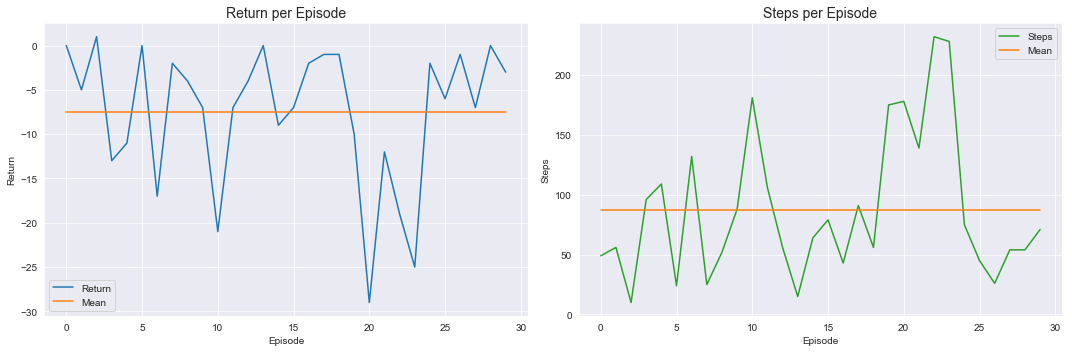

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

sns.set_style("darkgrid")
pallete = sns.color_palette()

mean_return = [np.mean(episode_returns) for i in range(num_episodes)]
mean_length = [np.mean(episode_length)  for i in range(num_episodes)]

fig = plt.figure(figsize=(15,5))

# Plot return per episode  
ax1 = fig.add_subplot(1,2,1)
ax1.plot(episode_returns, color=pallete[0])
ax1.plot(mean_return,     color=pallete[1])
ax1.legend(['Return','Mean'])
ax1.set_title("Return per Episode", fontsize=14)
plt.ylabel("Return")
plt.xlabel("Episode")

# Plot steps per episode
ax2 = fig.add_subplot(1,2,2)
ax2.plot(episode_length, color=pallete[2])
ax2.plot(mean_length,    color=pallete[1])
ax2.legend(['Steps','Mean'])
ax2.set_title("Steps per Episode", fontsize=14)
plt.ylabel("Steps")
plt.xlabel("Episode")

# Show the plot
plt.tight_layout()
plt.show()

In [22]:
print("Mean of Return Values: ", mean_return[0])
print("Mean of Steps per Epoch: ", mean_length[0])

Mean of Return Values:  -7.466666666666667
Mean of Steps per Epoch:  86.96666666666667


## Further Ideas

None, just start with the next notebook! :)

## Next: PIA - Reinforcement Learning: 2. Dynamic Programming